# GCAM Annual Meeting 2023 Tutorial

Will go here but for now, we're just testing the new functions we;ve added with
this notebook

- `stitches` defaults to $X=9$ year windows.


## Getting Started


In [1]:
import stitches


Load the additional python libraries that will be used in this example.  These packages are installed as `stitches` dependencies.

In [2]:
import os
import pkg_resources
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt



# For help with plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6


## Install the package data from Zenodo

The package data is all data that has been processed from raw Pangeo data
 and is generated with package functions. For convenience and rapid cloning
 of the github repository, the package data is also minted on Zenodo and
 can be quickly downloaded for using the package.
 

In [4]:
# stitches.install_package_data()

Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/matching_archive.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/pangeo_comparison_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/pangeo_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/matching_archive_staggered.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/NorESM2-LM_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/NorESM2-MM_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/BCC-ESM1_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/CESM2-FV2_tas.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/d

# Example Set Up

In this example, we will use `stitches` to emulate CanESM5 SSP245 results. Then we will compare the
`stitches` results with actual CMIP6 CanESM5 SSP245 output data.

#### Decide on the archive data

- Limit the archive matching data to the model we are trying to emulate, CanESM5 in this case.
- In this example, we treat SSP245 as a novel scenario rather than one
run by the ESM and available, so we exclude it from the archive data.
- The internal package data called `matching_archive` contains the temperature results for all the ESMs-Scenarios-ensemble
members that are available for `stitches` to use in its matching process. In this file monthly, tas output
has been processed to mean temperature anomaly and the temperature change over a window of time. By default
`stitches` uses a 9-year window.

In [3]:
# read in the package data of all ESMs-Scenarios-ensemble members avail.
data_directory = pkg_resources.resource_filename('stitches', "data")
path = os.path.join(data_directory, 'matching_archive_staggered.csv')
data = pd.read_csv(path)


Let's start from the final ESM year, 2100 for CanESM5, and prioritize getting that
as a full 9 year window. Short windows can be on the front end.

- if the final year for an ESM is 2099, you'd just do
`end_yr_vector = end_yr_vector-1` to shift everything up a year.

In [4]:
staggered_archive = data.copy()

end_yr_vector = [1857, 1866, 1875,1884, 1893,
                 1902, 1911, 1920, 1929, 1938, 1947,
                 1956,  1965, 1974, 1983, 1992, 2001,
                 2010, 2019, 2028, 2037, 2046, 2055,
                 2064, 2073, 2082, 2091, 2100]

tmp = staggered_archive.loc[(data["experiment"].isin(['ssp126', 'ssp370', 'ssp585']))
                       & (data["model"] == "CanESM5")].copy()
archive_data = stitches.fx_processing.subset_archive(staggered_archive = tmp,
                                            end_yr_vector = end_yr_vector)

print(archive_data)

     experiment variable    model   ensemble  start_yr  end_yr  year  \
0        ssp126      tas  CanESM5  r10i1p1f1      1858    1866  1862   
1        ssp126      tas  CanESM5  r10i1p1f1      1867    1875  1871   
2        ssp126      tas  CanESM5  r10i1p1f1      1876    1884  1880   
3        ssp126      tas  CanESM5  r10i1p1f1      1885    1893  1889   
4        ssp126      tas  CanESM5  r10i1p1f1      1894    1902  1898   
...         ...      ...      ...        ...       ...     ...   ...   
2020     ssp585      tas  CanESM5   r9i1p1f1      2056    2064  2060   
2021     ssp585      tas  CanESM5   r9i1p1f1      2065    2073  2069   
2022     ssp585      tas  CanESM5   r9i1p1f1      2074    2082  2078   
2023     ssp585      tas  CanESM5   r9i1p1f1      2083    2091  2087   
2024     ssp585      tas  CanESM5   r9i1p1f1      2092    2100  2096   

            fx        dx  
0    -1.299509 -0.001848  
1    -1.225040  0.010931  
2    -1.205325 -0.012385  
3    -1.299790  0.004692  


The staggered archive ONLY has 9 year windows, no short windows. So no window
from 1850-1857 exists to get pulled for that `end_yr`. That's fine because  the
historical period is so consistent, there are plenty of other full sized (9year)
windows that have similar properties and can make for a good match, so we aren't
really losing anything by not having archive points representing 1850-1857.
If we really want, we can go ahead and have an 1850-1858 window in the archive
by just replacing 1857 with 1858 in the above. There will be on year (1858) in
common between that new window and the one ending in 1866 but that's not
an amount of similarity that would lead to unrealistic behavior like if we used
all of the entries in the staggered archive.

And that would look like:

In [5]:
end_yr2 = [1858, 1866, 1875,1884, 1893,
           1902, 1911, 1920, 1929, 1938, 1947,
           1956,  1965, 1974, 1983, 1992, 2001,
           2010, 2019, 2028, 2037, 2046, 2055,
           2064, 2073, 2082, 2091, 2100]
archive_data2 = stitches.fx_processing.subset_archive(staggered_archive = tmp,
                                      end_yr_vector = end_yr2).sort_values(by=['experiment', 'ensemble', 'end_yr'])
print(archive_data2)

     experiment variable    model   ensemble  start_yr  end_yr  year  \
0        ssp126      tas  CanESM5  r10i1p1f1      1850    1858  1854   
75       ssp126      tas  CanESM5  r10i1p1f1      1858    1866  1862   
76       ssp126      tas  CanESM5  r10i1p1f1      1867    1875  1871   
77       ssp126      tas  CanESM5  r10i1p1f1      1876    1884  1880   
78       ssp126      tas  CanESM5  r10i1p1f1      1885    1893  1889   
...         ...      ...      ...        ...       ...     ...   ...   
2095     ssp585      tas  CanESM5   r9i1p1f1      2056    2064  2060   
2096     ssp585      tas  CanESM5   r9i1p1f1      2065    2073  2069   
2097     ssp585      tas  CanESM5   r9i1p1f1      2074    2082  2078   
2098     ssp585      tas  CanESM5   r9i1p1f1      2083    2091  2087   
2099     ssp585      tas  CanESM5   r9i1p1f1      2092    2100  2096   

            fx        dx  
0    -1.360399  0.016472  
75   -1.299509 -0.001848  
76   -1.225040  0.010931  
77   -1.205325 -0.012385  


# Target
It's easiest to just only have a target start in 1858 and go to 2100. For GCAM,
that's fine. Mostly, 1975-2100 is the window you'd need covered for GCAM and
that segments into 9 year chunks perfectly.

In [6]:
targ = pd.read_csv(os.path.join(data_directory, "tas-data", "CanESM5_tas.csv"))
target_data = targ.loc[(targ["model"] == "CanESM5")
                       & (targ["experiment"] == 'ssp245')].copy()

target_data  = target_data[target_data["ensemble"].isin(['r1i1p1f1'])].copy()

target_data = target_data.drop(columns='zstore').reset_index(drop=True)


target_data = stitches.fx_processing.calculate_rolling_mean(target_data,
                                                            size=31).copy()

The default chunking, starting with 1850 and cutting every 9 years after that.
This results in the final window only being 8 years. That is fine, a target window
that is only 1 year short is not a problem (shorter than that is also not a problem
for the method, we just haven't coded that in).

In [8]:
target_data1 = stitches.fx_processing.get_chunk_info(
    stitches.fx_processing.chunk_ts(df = target_data,  n=9)).copy()
print(target_data1)

   variable experiment    model  ensemble  start_yr  end_yr  year        fx  \
0       tas     ssp245  CanESM5  r1i1p1f1      1850    1858  1854 -1.272611   
1       tas     ssp245  CanESM5  r1i1p1f1      1859    1867  1863 -1.250102   
2       tas     ssp245  CanESM5  r1i1p1f1      1868    1876  1872 -1.243684   
3       tas     ssp245  CanESM5  r1i1p1f1      1877    1885  1881 -1.204998   
4       tas     ssp245  CanESM5  r1i1p1f1      1886    1894  1890 -1.197851   
5       tas     ssp245  CanESM5  r1i1p1f1      1895    1903  1899 -1.213103   
6       tas     ssp245  CanESM5  r1i1p1f1      1904    1912  1908 -1.170853   
7       tas     ssp245  CanESM5  r1i1p1f1      1913    1921  1917 -1.145708   
8       tas     ssp245  CanESM5  r1i1p1f1      1922    1930  1926 -1.086683   
9       tas     ssp245  CanESM5  r1i1p1f1      1931    1939  1935 -1.012161   
10      tas     ssp245  CanESM5  r1i1p1f1      1940    1948  1944 -0.986856   
11      tas     ssp245  CanESM5  r1i1p1f1      1949 

If you'd rather the target window ending in 2100 be a complete 9 years and work
back, you can use the `base_chunk=8` argument to do that. The previous call starting
in 1850 and cutting every 9 years aftere that uses the default `base_chunk=0`.
`base_chunk=8` means the target starts in 1850+8 = 1858 and cuts every 9
years after that, ending in 2100.

If the ESM data ends in 2099 and you wanted the target window ending in 2099
to be a complete 9 year window, you'd use `base_chunk=7`. It's a little clunky and
we could certainly make it more interpretable/flexible, but it's not too bad to
figure out for now.

In [9]:
target_data2 = stitches.fx_processing.get_chunk_info(
    stitches.fx_processing.chunk_ts(df = target_data,  n=9,
                                    base_chunk=8)).copy()
print(target_data2)

   variable experiment    model  ensemble  start_yr  end_yr  year        fx  \
0       tas     ssp245  CanESM5  r1i1p1f1      1858    1866  1862 -1.254450   
1       tas     ssp245  CanESM5  r1i1p1f1      1867    1875  1871 -1.242954   
2       tas     ssp245  CanESM5  r1i1p1f1      1876    1884  1880 -1.214581   
3       tas     ssp245  CanESM5  r1i1p1f1      1885    1893  1889 -1.195424   
4       tas     ssp245  CanESM5  r1i1p1f1      1894    1902  1898 -1.200969   
5       tas     ssp245  CanESM5  r1i1p1f1      1903    1911  1907 -1.172773   
6       tas     ssp245  CanESM5  r1i1p1f1      1912    1920  1916 -1.145221   
7       tas     ssp245  CanESM5  r1i1p1f1      1921    1929  1925 -1.091947   
8       tas     ssp245  CanESM5  r1i1p1f1      1930    1938  1934 -1.022043   
9       tas     ssp245  CanESM5  r1i1p1f1      1939    1947  1943 -0.994382   
10      tas     ssp245  CanESM5  r1i1p1f1      1948    1956  1952 -0.955606   
11      tas     ssp245  CanESM5  r1i1p1f1      1957 

if you really don't want to sacrifice the 1850-1857 years, you can get
kind of clunky and play around with the `chunk_ts` arguments to get an
1850-1857 chunk and just append that to the target data

In [10]:
short_target_window = stitches.fx_processing.get_chunk_info(
    stitches.fx_processing.chunk_ts(df = target_data,  n=8,
                                    base_chunk=0)).copy()

short_target_window = short_target_window[short_target_window['end_yr'] == 1857].copy()

print(short_target_window)

  variable experiment    model  ensemble  start_yr  end_yr  year        fx  \
0      tas     ssp245  CanESM5  r1i1p1f1      1850    1857  1854 -1.272611   

        dx  
0  0.00468  


In [11]:
target_data3 = pd.concat([short_target_window, target_data2]).reset_index(drop=True)
print(target_data3)


   variable experiment    model  ensemble  start_yr  end_yr  year        fx  \
0       tas     ssp245  CanESM5  r1i1p1f1      1850    1857  1854 -1.272611   
1       tas     ssp245  CanESM5  r1i1p1f1      1858    1866  1862 -1.254450   
2       tas     ssp245  CanESM5  r1i1p1f1      1867    1875  1871 -1.242954   
3       tas     ssp245  CanESM5  r1i1p1f1      1876    1884  1880 -1.214581   
4       tas     ssp245  CanESM5  r1i1p1f1      1885    1893  1889 -1.195424   
5       tas     ssp245  CanESM5  r1i1p1f1      1894    1902  1898 -1.200969   
6       tas     ssp245  CanESM5  r1i1p1f1      1903    1911  1907 -1.172773   
7       tas     ssp245  CanESM5  r1i1p1f1      1912    1920  1916 -1.145221   
8       tas     ssp245  CanESM5  r1i1p1f1      1921    1929  1925 -1.091947   
9       tas     ssp245  CanESM5  r1i1p1f1      1930    1938  1934 -1.022043   
10      tas     ssp245  CanESM5  r1i1p1f1      1939    1947  1943 -0.994382   
11      tas     ssp245  CanESM5  r1i1p1f1      1948 

Look at the message for the matching, using the target that has a short 1850-1857
window and the archive that has 1858 data get included in two chunks. This is kind
of our hackiest, most unrealistic case.

In [12]:
# Verify that the default nearest neighbor matches all have distances < 0.25degC
# making sure the print statement in our matching is right.
out = stitches.fx_match.match_neighborhood(target_data=target_data3,
                                     archive_data= archive_data2, tol =0)
print(out.dist_l2)

# do the actual match with a tolerance so we get a couple
out = stitches.fx_match.match_neighborhood(target_data=target_data3,
                                     archive_data= archive_data2, tol =0.05)
print(out.head())

0     0.003430
1     0.008916
2     0.011961
3     0.007662
4     0.015203
5     0.007713
6     0.007355
7     0.006999
8     0.010817
9     0.015191
10    0.004343
11    0.006810
12    0.016096
13    0.015813
14    0.021051
15    0.064679
16    0.101602
17    0.004186
18    0.012314
19    0.013757
20    0.044243
21    0.057602
22    0.099079
23    0.150805
24    0.121686
25    0.223116
26    0.231118
27    0.246489
Name: dist_l2, dtype: float64
  target_variable target_experiment target_ensemble target_model  \
0             tas            ssp245        r1i1p1f1      CanESM5   
1             tas            ssp245        r1i1p1f1      CanESM5   
2             tas            ssp245        r1i1p1f1      CanESM5   
3             tas            ssp245        r1i1p1f1      CanESM5   
4             tas            ssp245        r1i1p1f1      CanESM5   

   target_start_yr  target_end_yr  target_year  target_fx  target_dx  \
0             1850           1857         1854  -1.272611    0.00468 

Do some matches and plotting - note we'll get extra  messages  about the nn
matches because the permute stitching recipe redraws the next nearest
neighbor when the same archive window is the nearest neighbor to 2 target
windows.

Note that for ESMs covered in the ESD paper, we have pre-validated for tolerances
up to the Zcutoff values described in that paper.

In [13]:
my_recipes = stitches.make_recipe(target_data3,
                                  archive_data2,
                                  tol=0.0,
                                  N_matches=4,
                                  reproducible=True)


stitched_global_temp = stitches.gmat_stitching(my_recipes)

You have requested more recipes than possible for at least one target trajectories, returning what can
The following target windows have a nearest neighbor in T, dT space
that is more than 0.25degC away. This may or may not result in poor
matches and we recommend validation.
  target_variable target_experiment target_ensemble target_model  \
0             tas            ssp245        r1i1p1f1      CanESM5   

   target_start_yr  target_end_yr  target_year  target_fx  target_dx  \
0             2083           2091         2087   2.832238   0.012831   

  archive_experiment  ... archive_model archive_ensemble archive_start_yr  \
0             ssp370  ...       CanESM5        r17i1p1f1             2056   

   archive_end_yr  archive_year  archive_fx  archive_dx   dist_dx   dist_fx  \
0            2064          2060    2.815717    0.045724  0.263149  0.016521   

    dist_l2  
0  0.263667  

[1 rows x 21 columns]
-----------------------------------------------------------------------------

## visualize

### stitched realization

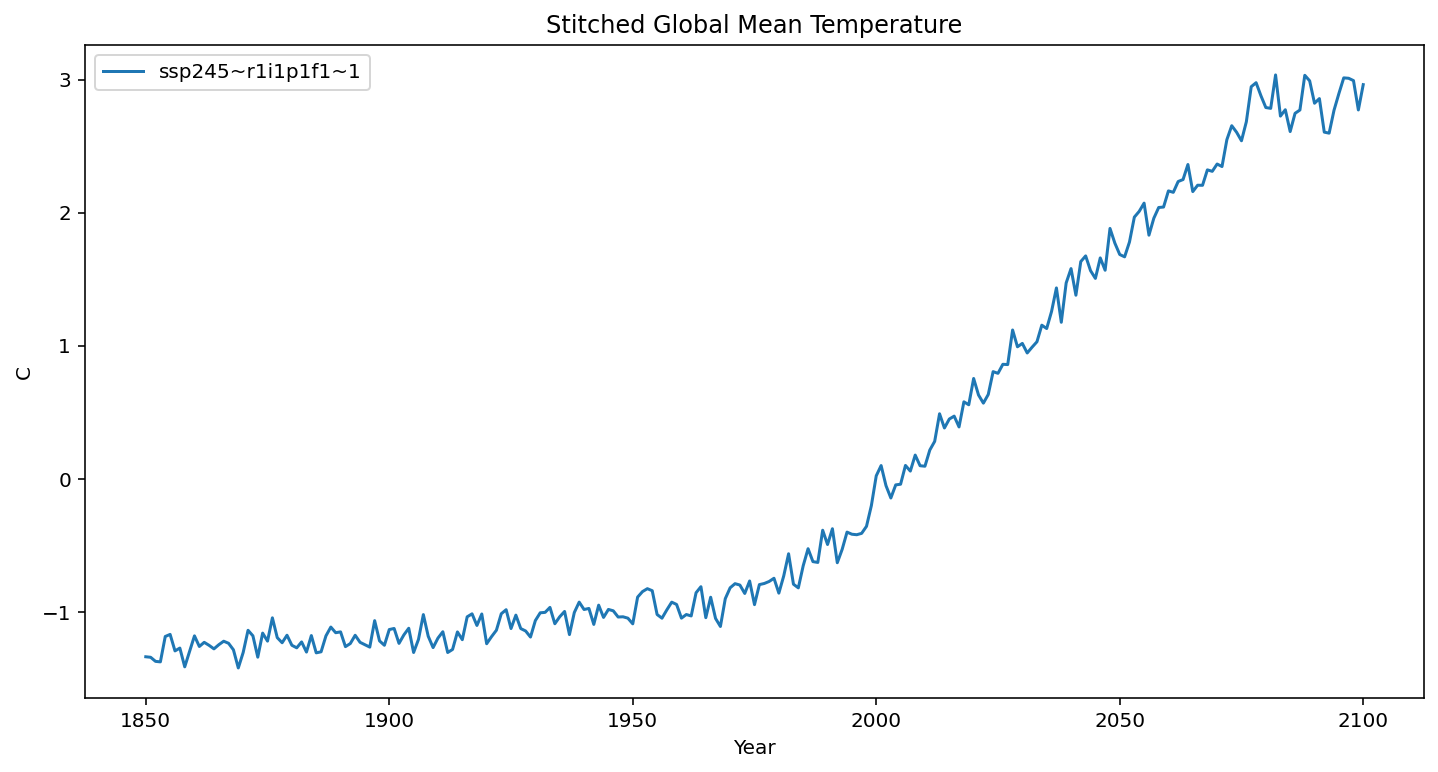

In [14]:
groups = stitched_global_temp.groupby('stitching_id')

for name, group in groups:
    plt.plot(group.year, group.value, label = name)

plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature")
plt.legend()
plt.show()
plt.close()



# Load the comparison GSAT data
data_directory = pkg_resources.resource_filename("stitches", "data")
data_path = os.path.join(data_directory, "tas-data", "CanESM5_tas.csv")

comp_data = pd.read_csv(data_path)
comp_data = comp_data.loc[comp_data["experiment"] == "ssp245"]


### stitched realization and the target ensemble member

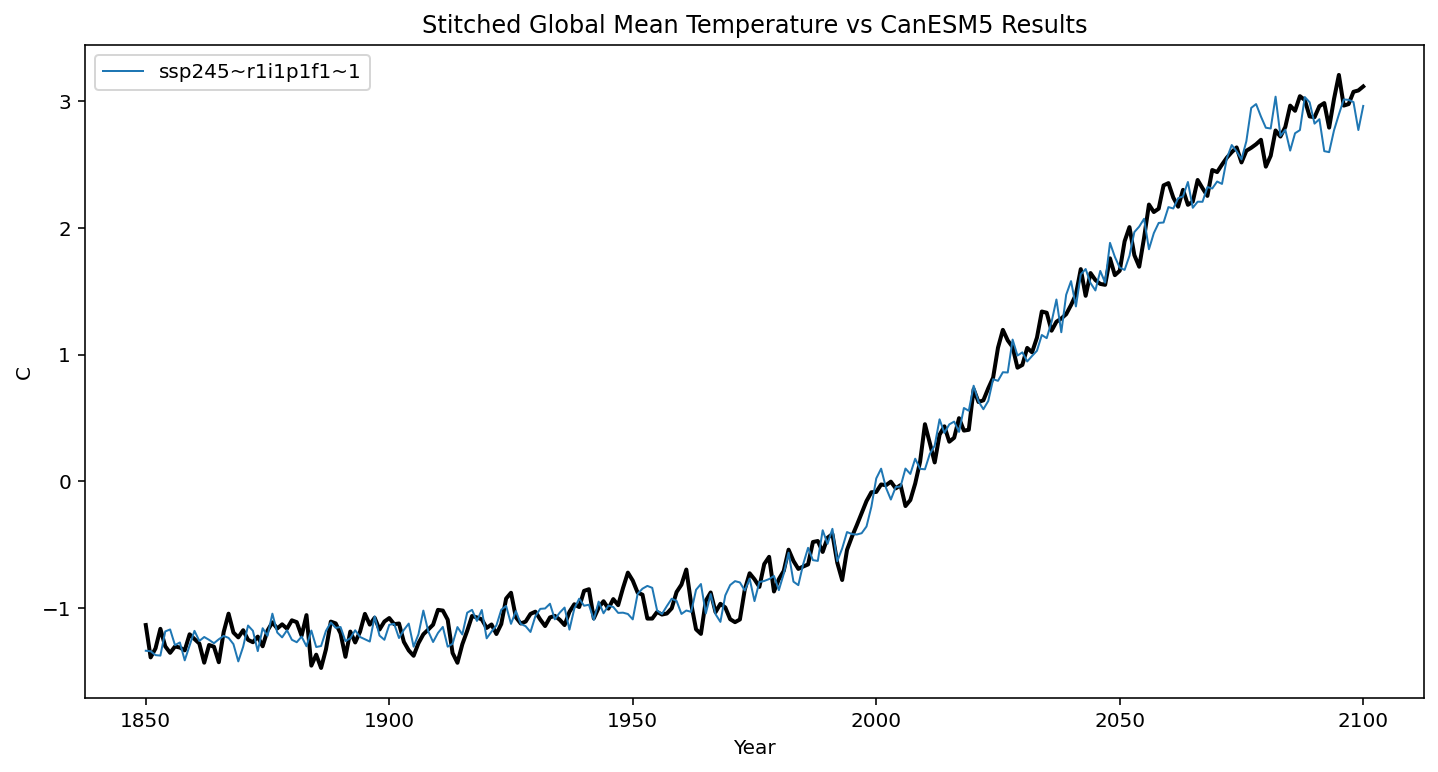

In [15]:
groups = comp_data.groupby('ensemble')
for name, group in groups:
    if(group.ensemble.unique() == 'r1i1p1f1'):
        plt.plot(group.year, group.value, color = "black", linewidth = 2.0)
# The stitched realizations:
groups = stitched_global_temp.groupby('stitching_id')
for name, group in groups:
    plt.plot(group.year, group.value, linewidth= 1.0, label = name)

plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature vs CanESM5 Results")
plt.show()
plt.close()

### stitched realization and the entire scenario ensemble

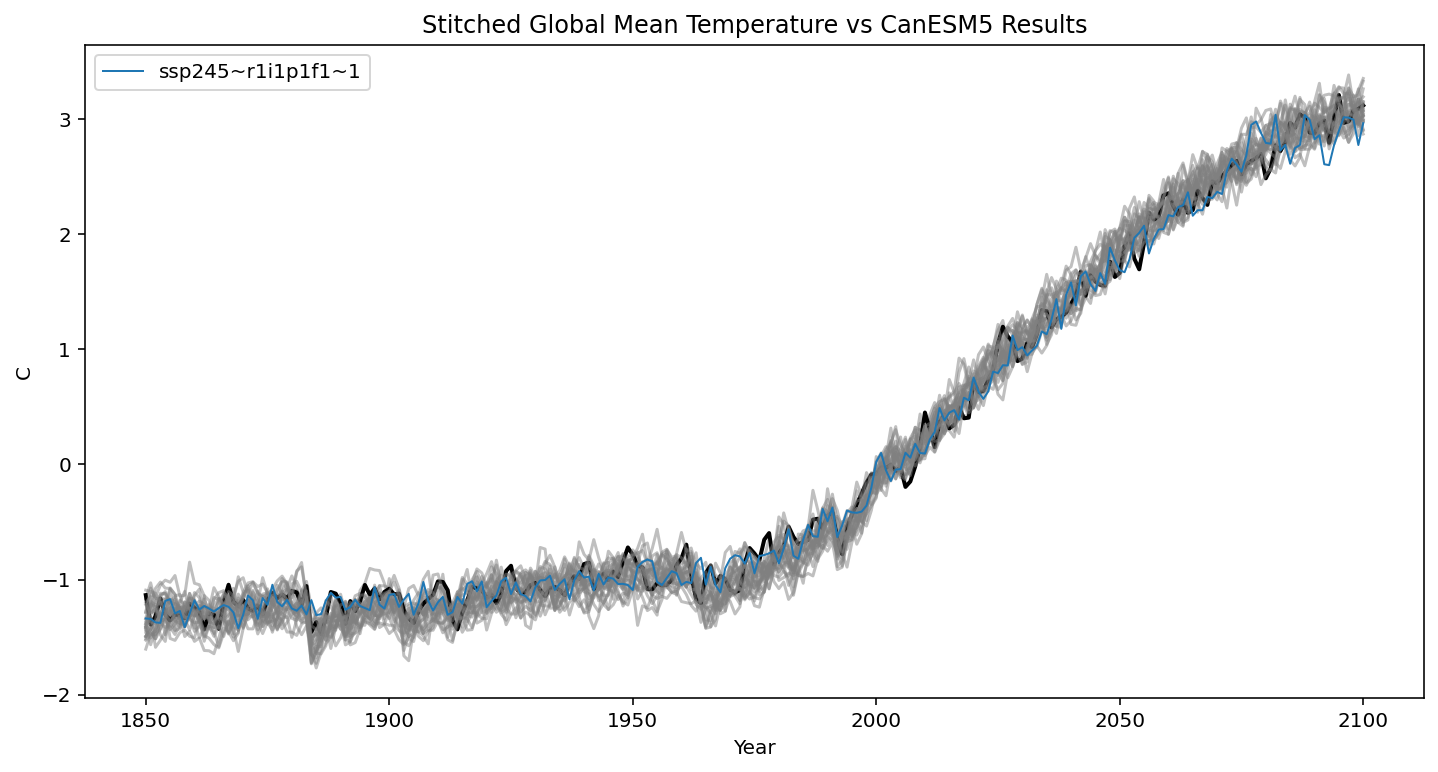

In [16]:
# full ensemble of actual ESM runs:
groups = comp_data.groupby('ensemble')
for name, group in groups:
    if(group.ensemble.unique() == 'r1i1p1f1'):
        plt.plot(group.year, group.value, color = "black", linewidth = 2.0)
    else:
        plt.plot(group.year, group.value, color = "0.5", alpha=0.5)

# The stitched realizations:
groups = stitched_global_temp.groupby('stitching_id')
for name, group in groups:
    plt.plot(group.year, group.value, linewidth= 1.0, label = name)

plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature vs CanESM5 Results")
plt.show()
plt.close()



# gridded check
again on our weirdest stuff a short first target window 1850-1857, and 1858
being repeated in two separate archive windows.

basically just a sanity check that the functions can handle stitching in gridded data
without error even for the short (8 year only, not shorter for now) target window.

In [17]:
my_recipes = stitches.make_recipe(target_data3,
                                  archive_data2,
                                  tol=0.1,
                                  non_tas_variables=['pr'],
                                  N_matches=1,
                                  reproducible=True)

basically just a sanity check that the functions can handle stitching in gridded data
without error even for the short (8 year only, not shorter for now) target window.

In [18]:
stitches.gridded_stitching(out_dir='.',  rp=my_recipes)

['Stitching gridded netcdf for: CanESM5 tas ssp245~r1i1p1f1~1']


['./stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc',
 './stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc']